In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from astropy.io import fits
from scipy.stats import norm, truncnorm
import sep, glob, GCRCatalogs, matplotlib
from scipy.optimize import root
from tqdm import tqdm
import pandas as pd

/global/homes/e/esilver/.local/perlmutter/python-3.11/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
#options are Zahid and Collet
method='Zahid' 
#options are 'source_in_lens' (Method A), 'lens_in_source' (Method B), and 'both' (Method C)
counting='both'
#Default number of samples is 100,000: use this to increase samples
sample_size_factor = 10
#home directory with data
home = "/global/cfs/projectdirs/deepsrch/jwst_sims/data/"
#Loads CosmoDC2 catalog
cat = GCRCatalogs.load_catalog("desc_cosmodc2")

In [3]:
#Collett (2015) statistics, generated using LensPop

c_sig = np.load(home+"lenspop/lens_sig_3.npy", encoding="latin1",allow_pickle=True)
c_z = np.load(home+"lenspop/lens_z_3.npy", encoding="latin1",allow_pickle=True)
c_thetaE = np.array([])
for i in range(len(c_sig)):
    lens_cosmo = LensCosmo(c_z[i],6)
    te = lens_cosmo.sis_sigma_v2theta_E(c_sig[i])
    c_thetaE = np.append(c_thetaE, te)
bins = np.arange(0,2.0,0.1)
n, bins = np.histogram(c_thetaE, bins=bins)

In [4]:
#Sets up CosmoDC2 data to be drawn from
keys = ['redshift', 'halo_mass', 'stellar_mass', 'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'is_central']
dc2 = cat.get_quantities(keys)

ra, dec = cat.get_quantities(['ra_true'])['ra_true'], cat.get_quantities(['dec_true'])['dec_true']
ra_dc2, dec_dc2 = ra-ra.mean(), dec-dec.mean()
#Parallelogram of area covered by Cosmo DC2
area_dc2 = (ra.max()-ra.min())*(dec.max()-dec.min())/2

In [5]:
#JWST star-forming and quiescent mock catalogs (Williams et al. (2018))
with fits.open(home+'JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    dataq = hdul[1].data
#'sad' is the Source Area in Degrees squared
ra_source, dec_source = dataq['RA']-dataq['RA'].mean(), dataq['DEC']-dataq['DEC'].mean()
sad = (ra_source.max()-ra_source.min())*(dec_source.max()-dec_source.min()) #source area degrees

with fits.open(home+'JWST/JADES_Q_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    dataq2 = hdul[1].data
    headerq = hdul[1].header
#Selects rectangle on the sky to use
dataq = dataq[dataq['RA']>53.137];dataq = dataq[dataq['RA']<53.222]
dataq = dataq[dataq['DEC']>-27.83];dataq = dataq[dataq['DEC']<-27.785]
dataq2 = dataq2[dataq2['RA']>53.137];dataq2 = dataq2[dataq2['RA']<53.222]
dataq2 = dataq2[dataq2['DEC']>-27.83];dataq2 = dataq2[dataq2['DEC']<-27.785]

from astropy.table import Table, vstack
from astropy.io.fits import FITS_rec
data = vstack([Table(dataq),Table(dataq2)])
data['ra'] = data['RA']; data['dec']=data['DEC']

In [6]:
#Range of source redshifts
z_sources = np.logspace(np.log10(max(data['redshift'])), np.log10(min(data['redshift'])), 20)
z_source_means = (z_sources[1:]+z_sources[:-1])/2

In [7]:
#JWST image (Williams et al. (2018))
with fits.open(home+'JWST/goods_s_F115W_2018_08_29.fits') as hdul:
    data3 = hdul[0].data
    header3 = hdul[0].header
from astropy.wcs import WCS
w = WCS(header3)
from astropy.coordinates import SkyCoord
region = data3[5000:6000,7000:9000]*1
#Average background level
bkg = sep.Background(np.array(region)).globalrms
bkg

0.001607376616448164

In [8]:
with fits.open(home+'JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    data0 = hdul[1].data
    header = hdul[1].header
ra_source, dec_source = data['RA']-data['RA'].mean(), data['DEC']-data['DEC'].mean()
sad = (ra_source.max()-ra_source.min())*(dec_source.max()-dec_source.min()) #source area degrees


In [9]:
#Statistical count, counting sources over lens area
import time
start = time.time()

#converts between normalization of Collett and CosmoDC2 distributions
number_ratio = 0.017399272857057335

#Total array of Einstein radii
TES=[]
#Masses of the lenses
masses_used=[]
#Sources per lens above 0.05", 0.1", 0.5", 1.0"
sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100 = [],[],[],[]

lens_masses = dc2['halo_mass'].copy()
#Lower mass limit is for speed, upper is to exclude huge cluster lenses
sel = (lens_masses>1e9)*(lens_masses<1e14)

ms = lens_masses[sel]
zs = dc2['redshift'][sel]
rng = np.random.default_rng(seed=5)
inds = rng.choice(len(ms), size=100000*sample_size_factor,replace=False)
inds = inds[dc2['is_central'][sel][inds]==True]

ms = ms[inds]
zs = zs[inds]
source_nums = np.zeros(len(z_source_means))
#Total lensed areas above 0.05", 0.1", 0.5", 1.0"
lens_areas_005 = np.zeros(len(z_source_means))
lens_areas_010 = np.zeros(len(z_source_means))
lens_areas_050 = np.zeros(len(z_source_means))
lens_areas_100 = np.zeros(len(z_source_means))

#Iterates over the redshift slices
for zi in (range(len(z_source_means))):
    sources = data[data['redshift']<z_sources[zi]]
    sources = sources[sources['redshift']>z_sources[zi+1]]
    
    source_areas = []

    #Counts all of the sources within the redshift bin that are bright enough
    for source in range(len(sources)):
        R = int(sources[source]['Re_maj']/.03*5)
        #counting if any pixel has brightness >5*BKG, using sep
        if R>0:
            ra, dec = sources[source]['RA'], sources[source]['DEC']
            sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
            x, y = w.world_to_pixel(sky)
            x, y = int(x), int(y)
            gal = data3[y-R:y+R,x-R:x+R]
            objects, segmap = sep.extract(np.array(gal).byteswap().newbyteorder(), 1.5, err=bkg, segmentation_map=True)
            segmap[segmap!=segmap[R,R]]=0
            
            if np.count_nonzero(gal[segmap!=0]>5*bkg)>=1:
                source_nums[zi] += 1
                source_areas.append(np.sum(gal[segmap!=0]>5*bkg)*(.03/60/60)**2)
       
        # #counting if brightness above a magnitude cut
        # F_nu = sources[source]['HST_F775W_fnu']*1e-9
        # ABmag = -2.5*np.log10(F_nu) + 8.90
        # if ABmag < 27:
        #     source_nums[zi] += 1

    TESz = []
    masses_used_z = []
    sources_per_lens_z_005,sources_per_lens_z_010,sources_per_lens_z_050,sources_per_lens_z_100  = [],[],[],[]
    #Counts the total lens area at the center of the current redshift slice
    for lens in tqdm(range(len(ms)), desc="Redshift Slice "+str(1+zi)+"/"+str(len(z_source_means)), leave=False):
        if zs[lens] < z_source_means[zi]:
            lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=z_source_means[zi])

            if method=='Zahid':
                alpha, beta, scatter = 0.16, 3.31, 0.17
                sig = 100*10**((np.log10(ms[lens]/1e12)-alpha)/beta)
                sig += norm.rvs(loc=0,scale=np.log(10)/beta*sig*0.17)
                
            elif method=='Collett':
                sig = np.random.choice(c_sig)
            else:
                raise Exception("Not a valid method.")
            
            theta_E = lens_cosmo.sis_sigma_v2theta_E(sig)
            TESz.append(theta_E)
            masses_used_z.append(ms[lens])
            
            TEarea = np.pi*(theta_E/60/60)**2
            if len(source_areas)>0:
                #Source area
                sArea = np.random.choice(source_areas)
                source_radius = np.sqrt(sArea/np.pi)
                #Total radius is how far away the lens and source can be
                if counting=='source_in_lens':
                    total_radius = theta_E/60/60
                elif counting=='lens_in_source':
                    total_radius = source_radius
                elif counting=='both':
                    total_radius = max(source_radius, theta_E/60/60)
                else:
                    raise Exception("Not a valid counting choice.")
                TEarea = np.pi*(total_radius)**2
            else:
                Tearea=0
            
            #Counts the individual Einstein radius bins conveniently
            if theta_E>.05:
                sources_per_lens_z_005.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_005.append(0)
            if theta_E>.10:
                sources_per_lens_z_010.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_010.append(0)
            if theta_E>.50:
                sources_per_lens_z_050.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_050.append(0)
            if theta_E>1.00:
                sources_per_lens_z_100.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_100.append(0)

            
            if theta_E>.05:
                lens_areas_005[zi] += TEarea
            if theta_E>0.10:
                lens_areas_010[zi] += TEarea
            if theta_E>0.50:
                lens_areas_050[zi] += TEarea
            if theta_E>1.00:
                # print(theta_E)
                lens_areas_100[zi] += TEarea
        else:
            TESz.append(0)
            masses_used_z.append(0)
            sources_per_lens_z_005.append(0),sources_per_lens_z_010.append(0),sources_per_lens_z_050.append(0),sources_per_lens_z_100.append(0)
    TESz = np.array(TESz)
    TES.append(TESz)

    masses_used_z = np.array(masses_used_z)
    masses_used.append(masses_used_z)
    
    sources_per_lens_005.append(np.array(sources_per_lens_z_005)),sources_per_lens_010.append(np.array(sources_per_lens_z_010)),sources_per_lens_050.append(np.array(sources_per_lens_z_050)),sources_per_lens_100.append(np.array(sources_per_lens_z_100))
TES = np.array(TES)
masses_used = np.array(masses_used)

sources_per_lens_005 = np.array(sources_per_lens_005)
sources_per_lens_010 = np.array(sources_per_lens_010)
sources_per_lens_050 = np.array(sources_per_lens_050)
sources_per_lens_100 = np.array(sources_per_lens_100)
if method=='Collett':
    sources_per_lens_005 = sources_per_lens_005*number_ratio
    sources_per_lens_010 = sources_per_lens_010*number_ratio
    sources_per_lens_050 = sources_per_lens_050*number_ratio
    sources_per_lens_100 = sources_per_lens_100*number_ratio

print(time.time()-start)

1642.608657836914


In [10]:
def counts_per_deg(te):
    if te==0.05:
        lens_areas = lens_areas_005.copy()
    elif te==0.10:
        lens_areas = lens_areas_010.copy()
    elif te==0.50:
        lens_areas = lens_areas_050.copy()
    elif te==1.00:
        lens_areas = lens_areas_100.copy()
    counts_per_deg = np.zeros(len(TES))
    for i in range(len(TES)):
        sources_per_deg = source_nums[i] / sad
        # lenses_per_deg = len(lenses)*len(masses2)/len(ms)/(11*11/60/60)

        counts_per_deg[i] = sources_per_deg * lens_areas[i] * np.sum(sel)/len(ms)/area_dc2
    print(te, np.sum(counts_per_deg), np.sum(source_nums/sad),np.sum(counts_per_deg)/np.sum(source_nums/sad))
    return np.sum(counts_per_deg)
print()  
a = np.array([counts_per_deg(.05), counts_per_deg(.1), counts_per_deg(.5),  counts_per_deg(1)])
if method=='Collett':
    a = a*number_ratio
# print(a)
print(a*41523)


0.05 903.17174306125 2799459.231289724 0.0003226236456550055
0.1 486.3669282094242 2799459.231289724 0.0001737360282919186
0.5 180.4651706985311 2799459.231289724 6.44642967761277e-05
1 81.0052637787962 2799459.231289724 2.893603981561707e-05
[37502400.28713229 20195413.96003992  7493455.28291511  3363581.56788695]


0.599423396494146


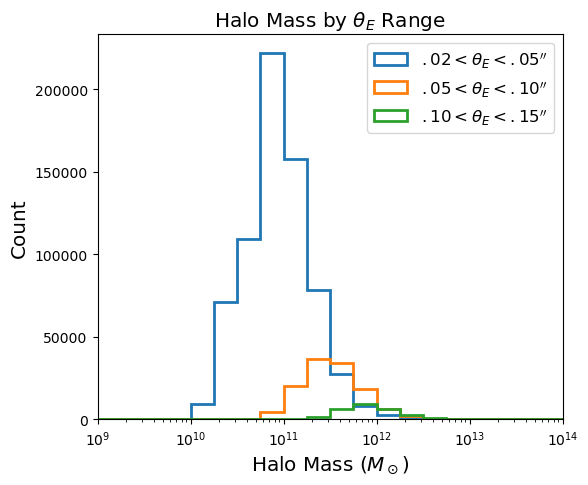

In [21]:
#Plot of forecast Halo Mass by Einstein radius range
log=False
plt.figure(dpi=100,figsize=(6,5))
mass = (masses_used.flat)[(TES.flat<0.05)*(TES.flat>.02)]
plt.hist(mass, linewidth=2, bins=np.logspace(9,14,21), label=r"$.02<\theta_E<.05''$",histtype='step', log=log)
mass = (masses_used.flat)[(TES.flat<0.10)*(TES.flat>.05)]
plt.hist(mass, linewidth=2, bins=np.logspace(9,14,21), label=r"$.05<\theta_E<.10''$",histtype='step', log=log)
mass = (masses_used.flat)[(TES.flat<0.15)*(TES.flat>.10)]
plt.hist(mass, linewidth=2, bins=np.logspace(9,14,21), label=r"$.10<\theta_E<.15''$",histtype='step', log=log)

mass = (masses_used.flat)[(TES.flat<0.05)*(TES.flat>.02)]
frac = np.sum(mass<=1e11)/len(mass)
print(frac)
plt.xlabel(r'Halo Mass ($M_\odot$)', fontsize='x-large')
plt.ylabel('Count', fontsize='x-large')
plt.title(r"Halo Mass by $\theta_E$ Range", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.xlim(1e9,1e14)
plt.xscale('log')

In [11]:
#n_max_counted = max number of sources to consider 
#(eg. 2 = up to double sources)
n_max_counted = 2
#tots needed for the normalization
tots = np.zeros(4)
j=-1
sizes = [.05,0.1,0.5,1.0]
for sources_per_lens_i in [sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    # print("_____"+str(sizes[j])+"_____")
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni /= (number_ratio)**(i-1)
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        tots[j] += n_per_deg_i

In [12]:
#Follows formatting of Tables 1 and 2 in the paper
#(Just sum the rows of N=1,2,etc for the totals in Table 2)

print("N | fraction | per deg | on sky")
sizes = [0.05,0.10,0.50,1.00]
j=-1
for sources_per_lens_i in [sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    print("_____>"+str(sizes[j])+'"_____')
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni /= (number_ratio)**(i-1)
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        n_per_sky_i = n_per_deg_i * 41523
        print(i, round(n_per_deg_i/tots[j]*100,4), round(n_per_deg_i,4), round(n_per_sky_i,4))

N | fraction | per deg | on sky
_____>0.05"_____
1 96.14 817.41 33941315.4409
2 3.86 32.8186 1362725.7463
_____>0.1"_____
1 93.7451 411.696 17094852.1773
2 6.2549 27.4693 1140608.8579
_____>0.5"_____
1 85.7326 121.6178 5049935.3158
2 14.2674 20.2393 840397.2795
_____>1.0"_____
1 80.646 46.0123 1910570.5486
2 19.354 11.0424 458512.4337
